In [1]:
# Required libraries
import os
import math
import pims
from natsort import natsorted
import torch
import torch.nn as nn
from torch import Tensor
import random
import cv2 as cv
import numpy as np
import pandas as pd
import skimage as ski
from PIL import Image
import statistics
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
from typing import Any, Callable, List, Optional, Type, Union
from tqdm import tqdm # for calculating mean, stdev (https://kozodoi.me/blog/20210308/compute-image-stats)
from itertools import islice # for taking first n elements from an iterable (dataloader object)
from torchinfo import summary
import torchvision.transforms as T
import wandb
from datetime import datetime

from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.models import resnet101, ResNet101_Weights, resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import v2 as transforms

from transformers import AutoModel

# from pythae.models import AE, AEConfig, AutoModel
# from pythae.trainers import BaseTrainerConfig
# from pythae.pipelines.training import TrainingPipeline
# from pythae.models.nn.benchmarks.celeba import Encoder_ResNet_AE_CELEBA, Decoder_ResNet_AE_CELEBA, Encoder_Conv_AE_CELEBA, Decoder_Conv_AE_CELEBA, Encoder_ResNet_VAE_CELEBA
# from pythae.data.datasets import DatasetOutput
# from pythae.samplers import NormalSampler
from pythae.trainers.training_callbacks import WandbCallback

os.environ['WANDB_DATA_DIR'] = '/hps/nobackup/birney/users/esther/wandb/artifacts/staging/'
os.environ['WANDB_TIMEOUT'] = '120'
os.environ['JAVA_HOME'] = '/hps/nobackup/birney/users/esther/Fiji.app/java/linux-amd64/zulu8.60.0.21-ca-fx-jdk8.0.322-linux_x64/jre/'

In [2]:
! module load cuda/12.2.0

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.version.cuda)

12.1


In [4]:
torch.manual_seed(1)

In [5]:
# Set working directory
os.chdir('/nfs/research/birney/users/esther/medaka-img/src_files/')
model_dir = '/hps/nobackup/birney/users/esther/medaka-img/models/'

In [6]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ey267 (ey267-university-of-cambridge). Use `wandb login --relogin` to force relogin


True

## Build the CNN-based autoencoder
Feed a 224x224 image into the autoencoder

In [24]:
class AutoEncoderConv(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoderConv, self).__init__()
        # encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim[0], 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.embedding = nn.Linear(1024 * 14 * 14, latent_dim)

        # decoder
        self.deconv1 = nn.Sequential(nn.Linear(latent_dim, 1024 * 28 * 28))
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.deconv5 = nn.Sequential(
                nn.ConvTranspose2d(128, input_dim[0], 5, 1, padding=1), nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.embedding(x.reshape(x.shape[0], -1))
        x = self.deconv1(x)
        x = self.deconv2(x.reshape(x.shape[0], 1024, 28, 28))
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        return x

In [69]:
model = AutoEncoderConv((3, 224, 224), 1024)

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderConv                          [1, 3, 224, 224]          --
├─Sequential: 1-1                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-1                       [1, 128, 112, 112]        6,272
│    └─BatchNorm2d: 2-2                  [1, 128, 112, 112]        256
│    └─ReLU: 2-3                         [1, 128, 112, 112]        --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Conv2d: 2-4                       [1, 256, 56, 56]          524,544
│    └─BatchNorm2d: 2-5                  [1, 256, 56, 56]          512
│    └─ReLU: 2-6                         [1, 256, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 512, 28, 28]          2,097,664
│    └─BatchNorm2d: 2-8                  [1, 512, 28, 28]          1,024
│    └─ReLU: 2-9                         [1, 512, 28, 28]        

## Configure wandb

In [65]:
config = dict(
    epochs=101,
    batch_size=32,
    learning_rate=0.001,
    dataset="medaka-img-2024-10-03",
    architecture="Convolutional NN Autoencoder - train from scratch, custom mse loss",
    model="convnet-ae",
    train_img_rotation=10, # How much to rotate images during training
    ckpt_freq=50, # How often to save model checkpoints
    ckpt_dir=model_dir, # Directory to save model checkpoints
    reconstruction_table_freq=50, # How often to save reconstruction table

)

print(config['batch_size'])

32


## Load medaka data

In [7]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,1] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())

In [8]:
# Compose image transformations
# Based on testing below, MinMax scaling is the best normalization method for this dataset
# Using mean and std of the dataset for normalization is maybe not representative of the entire dataset,
# as the maximum value after normalization is 431.33228 (eg. subtracting the max pixel value, )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: transforms.functional.crop(img, 0, 0, 980, 1392)), # crop out bottom text
    transforms.Resize((224, 224)),
    # transforms.Resize((979, 979)), # resize to 979x979 to give 490x490 after first conv
    # transforms.RandomCrop(64), # crop to 64x64
    # transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)) # temporarily, to get the mean and stdev of the dataset
    # transforms.Normalize(mean=(0.035028, 0.000052371, 0.00043022), std=(0.0600, 0.0013, 0.0028))
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet normalization -> returns black images
    MinMaxScaling() # custom normalization
])

/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Flip all left-facing images to the right within the MedakaDataset class

In [9]:
# Read in dataframe indicating whether the fish is facing left or right
fish_direction_df= pd.read_csv("/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv")

# Only keep rows where the fish is facing left
fish_left_df = fish_direction_df[fish_direction_df['left_facing'] == 'left']
fish_left_df = fish_left_df.rename(columns={'Unnamed: 0': 'img_name'})

In [10]:
class MedakaDataset(Dataset):
    def __init__(self, csv_file, src_dir, transform=transform):
        self.image_paths = pd.read_csv(csv_file)['img_name']
        self.src_dir = src_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = f'{self.src_dir}/{img_name}'
                
        image = ski.io.imread(img_path)

        # Convert to tensor, crop out bottom text, and normalize
        if self.transform is not None:
            image = self.transform(image)

        # If facing left, flip the image horizontally
        if os.path.splitext(img_name)[0] in fish_left_df['img_name'].values:
            image = transforms.functional.hflip(image)

        return image.to(device), img_name # in script cannot use .to(device) here

In [11]:
# Load dataset
dataset = MedakaDataset(csv_file='train_set_2024-10-03.csv', 
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/raw_images', 
                                transform=transform)

train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

print(f"Total training set length: {len(dataset)}")
print(f"Train length: {train_len}")
print(f"Validation length: {val_len}")

test_dataset = MedakaDataset(csv_file='test_set_2024-10-03 copy.csv',
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/test_2024-10-03/raw_images',
                                transform=transform)
print("Test length: ", len(test_dataset))

Total training set length: 1112
Train length: 889
Validation length: 223
Test length:  1008


Implement checkpointing

In [40]:
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(checkpoint, filename)

def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

## Create training loop

In [41]:
random_trans = transforms.Compose([
        transforms.RandomRotation(config['train_img_rotation'])
    ])

In [63]:
import torch.nn.functional as F

class CustomMSELoss:
    def __call__(self, recon_x, x):
        MSE = F.mse_loss(
            recon_x.reshape(x.shape[0], -1), x.reshape(x.shape[0], -1), reduction="none"
        ).sum(dim=-1)
        return MSE.mean(dim=0)

In [61]:
def make(config):
    # Make the data
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    # Make the model
    model = AutoEncoderConv((3, 224, 224), 128).to(device)
    # model = AutoEncoder(num_input, num_hidden_0, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4).to(device)

    # Make the loss and optimizer
    # criterion = nn.MSELoss()
    criterion = CustomMSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config['learning_rate'])
    
    return model, train_loader, val_loader, criterion, optimizer

In [67]:
def train(model, train_loader, val_loader, criterion, optimizer, run_name, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Create wandb table
    columns = ["epoch", "id", "image", "reconstructed"]
    test_table = wandb.Table(columns=columns)

    # Run training and track with wandb
    example_ct = 0  # number of examples seen
    batch_ct = 0

    for epoch in tqdm(range(config['epochs'])):
        model.train()
        for image, image_name in train_loader:
            image = random_trans(image)
            # image = torch.reshape(random_trans(image),(-1, 224*224))
            train_loss = train_batch(image, model, optimizer, criterion)
            example_ct +=  len(image) # the batch size
            batch_ct += 1

        train_log(train_loss, example_ct, epoch)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for image, image_name in val_loader:
                # image = torch.reshape(image,(-1, 224*224))
                image = random_trans(image)
                image = image.to(device)
                output = model(image)
                loss = criterion(output, image)
                val_loss += loss.item()

            val_loss /= len(val_loader)
            wandb.log({"val_loss": val_loss}, step=epoch)
            print(f"Validation loss: {val_loss:.5f}")
            
        # Every 20th epoch, save model checkpoint
        if (epoch % 20 == 0) and (epoch != 0):
            # date_time = datetime.now().strftime("%Y%m%d%H%M%S")
            ckpt_name = f"ckpt-model-{config['model']}-run-{run_name}-epoch-{epoch}-val_loss-{val_loss:.5f}"    

            # save_checkpoint(model, optimizer, epoch, filename=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{ckpt_name}-{date_time}.pt')
            save_checkpoint(model, optimizer, epoch, filename=f'{model_dir}/checkpoints/convnet-ae-pytorch-medaka/{run_name}/{ckpt_name}.pt')

        #     # model_checkpoint = wandb.Artifact(
        #     #     name=ckpt_name,
        #     #     type="model").add_file(local_path=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{ckpt_name}-{date_time}.pt')

        #     # assert isinstance(model_checkpoint, wandb.Artifact), "model_checkpoint is not a wandb.Artifact"

        #     wandb.log_artifact(
        #         artifact_or_path=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{run_name}/{ckpt_name}.pt', 
        #         type="model-checkpoint",
        #         aliases=[f"model={config['model']}", f"architecture={config['architecture']}", f"epoch={epoch}", f"run={run_name}"])   


        # Every 50th epoch, output image reconstruction
        if (epoch % 5 == 0):
            print("Logging table at epoch", epoch)
            show_img, id = val_dataset[0]
            show_img = show_img.unsqueeze(0)
            recon_img = model(show_img.to(device)).cpu().detach().to(torch.float32)
            test_table.add_data(epoch, id, wandb.Image(show_img), wandb.Image(recon_img))
            test_table = wandb.Table(columns=columns, data=test_table.data)
            wandb.log({"Image reconstruction performance": test_table})


def train_batch(image, model, optimizer, criterion):
    image = image.to(device)
    
    # Forward pass
    output = model(image)
    loss = criterion(output, image)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "train loss": loss}, step=epoch)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.5f}")

In [57]:

def test(model, test_loader, criterion):
    wandb.define_metric("img_name")
    wandb.define_metric("test_loss", step_metric="img_name")
    columns = ["id", "image", "reconstructed"]
    test_set_table = wandb.Table(columns=columns)

    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        counter = 0
        for image, image_name in test_loader:
            image = image.to(device)
            output = model(image)
            loss = criterion(output, image)
            counter += 1
            log_dict = {"img_name": image_name, 
                        "test_loss": loss
                }

            print(f"Test Loss: {loss:.6f}")
            wandb.log(log_dict)

            if counter % 10 == 0:
                print("Logging table for image ", image_name)
                show_img = image
                recon_img = model(show_img.to(device)).cpu().detach().to(torch.float32)
                test_set_table.add_data(image_name, wandb.Image(show_img), wandb.Image(recon_img))
                test_set_table = wandb.Table(columns=columns, data=test_set_table.data)
                wandb.log({"Image reconstruction performance": test_set_table})
        
        # wandb.log({"vali": correct / total})

    # Save the model in the exchangeable ONNX format
    # torch.onnx.export(model, image, "model.onnx")
    # wandb.save("model.onnx")

In [66]:
model = AutoEncoderConv((3, 224, 224), 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(f'{model_dir}/checkpoints/convnet-ae-pytorch-medaka/amber-sweep-1/ckpt-model-convnet-ae-run-amber-sweep-1-epoch-499-time-2024-10-29-1820.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
criterion = nn.MSELoss()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [59]:
def model_pipeline(hyperparameters):
    run = wandb.init(project="convnet-ae-pytorch-medaka", config=hyperparameters)
    # tell wandb to get started
    with run:
      run_name = run.name
      # make the model, data, and optimization problem
      model, train_loader, val_loader, criterion, optimizer = make(hyperparameters)

      # and use them to train the model
      train(model, train_loader, val_loader, criterion, optimizer, run_name, hyperparameters)

      # and test its final performance
      # test(model, test_loader, nn.MSELoss())

    run.finish()

    return model, run_name

In [68]:
model, run_name = model_pipeline(config)

torch.cuda.empty_cache()
print(run_name)

  0%|          | 0/101 [00:00<?, ?it/s]

Loss after 00889 examples: 2411.09058
Validation loss: 9458.49777
Logging table at epoch 0


  1%|          | 1/101 [00:11<18:46, 11.26s/it]

Loss after 01778 examples: 1666.41064


  2%|▏         | 2/101 [00:21<17:42, 10.74s/it]

Validation loss: 4479.19148
Loss after 02667 examples: 1378.78564


  3%|▎         | 3/101 [00:30<15:53,  9.73s/it]

Validation loss: 1388.96211
Loss after 03556 examples: 1016.93042


  4%|▍         | 4/101 [00:38<15:08,  9.36s/it]

Validation loss: 1149.61586
Loss after 04445 examples: 1042.53564


  5%|▍         | 5/101 [00:47<14:26,  9.03s/it]

Validation loss: 1024.33153
Loss after 05334 examples: 844.74286
Validation loss: 954.20347
Logging table at epoch 5


  6%|▌         | 6/101 [00:56<14:21,  9.07s/it]

Loss after 06223 examples: 582.38361


  7%|▋         | 7/101 [01:04<13:53,  8.87s/it]

Validation loss: 539.51978
Loss after 07112 examples: 476.84100


  8%|▊         | 8/101 [01:13<13:43,  8.85s/it]

Validation loss: 535.29896
Loss after 08001 examples: 535.71960


  9%|▉         | 9/101 [01:22<13:25,  8.76s/it]

Validation loss: 528.62723
Loss after 08890 examples: 524.23743


 10%|▉         | 10/101 [01:30<13:12,  8.71s/it]

Validation loss: 522.90256
Loss after 09779 examples: 537.97040
Validation loss: 513.44735
Logging table at epoch 10


 11%|█         | 11/101 [01:39<13:11,  8.80s/it]

Loss after 10668 examples: 473.65543


 12%|█▏        | 12/101 [01:48<13:04,  8.82s/it]

Validation loss: 492.90963
Loss after 11557 examples: 505.05334


 13%|█▎        | 13/101 [01:57<12:49,  8.74s/it]

Validation loss: 476.98452
Loss after 12446 examples: 479.73856


 14%|█▍        | 14/101 [02:06<12:46,  8.81s/it]

Validation loss: 456.66415
Loss after 13335 examples: 447.03882


 15%|█▍        | 15/101 [02:14<12:30,  8.73s/it]

Validation loss: 433.78799
Loss after 14224 examples: 392.57538
Validation loss: 409.85845
Logging table at epoch 15


 16%|█▌        | 16/101 [02:24<12:41,  8.95s/it]

Loss after 15113 examples: 366.47464


 17%|█▋        | 17/101 [02:32<12:17,  8.78s/it]

Validation loss: 381.59423
Loss after 16002 examples: 412.39859


 18%|█▊        | 18/101 [02:41<12:13,  8.84s/it]

Validation loss: 379.86337
Loss after 16891 examples: 380.09464


 19%|█▉        | 19/101 [02:50<11:53,  8.71s/it]

Validation loss: 362.21371
Loss after 17780 examples: 374.83878


 20%|█▉        | 20/101 [02:58<11:47,  8.73s/it]

Validation loss: 344.06410
Loss after 18669 examples: 306.05936
Validation loss: 317.94823
Logging table at epoch 20


 21%|██        | 21/101 [03:11<13:16,  9.96s/it]

Loss after 19558 examples: 378.96646


 22%|██▏       | 22/101 [03:20<12:34,  9.55s/it]

Validation loss: 304.03134
Loss after 20447 examples: 324.65576


 23%|██▎       | 23/101 [03:29<12:14,  9.42s/it]

Validation loss: 308.11818
Loss after 21336 examples: 317.63455


 24%|██▍       | 24/101 [03:37<11:44,  9.15s/it]

Validation loss: 290.27842
Loss after 22225 examples: 242.77539


 25%|██▍       | 25/101 [03:46<11:27,  9.05s/it]

Validation loss: 269.24961
Loss after 23114 examples: 328.43945
Validation loss: 283.27160
Logging table at epoch 25


 26%|██▌       | 26/101 [03:55<11:21,  9.09s/it]

Loss after 24003 examples: 311.49780


 27%|██▋       | 27/101 [04:04<11:05,  8.99s/it]

Validation loss: 260.64697
Loss after 24892 examples: 312.42053


 28%|██▊       | 28/101 [04:13<10:44,  8.83s/it]

Validation loss: 272.11208
Loss after 25781 examples: 270.14481


 29%|██▊       | 29/101 [04:22<10:36,  8.83s/it]

Validation loss: 259.31459
Loss after 26670 examples: 232.80086


 30%|██▉       | 30/101 [04:30<10:19,  8.72s/it]

Validation loss: 237.92310
Loss after 27559 examples: 253.75343
Validation loss: 251.10644
Logging table at epoch 30


 31%|███       | 31/101 [04:39<10:23,  8.91s/it]

Loss after 28448 examples: 217.96555


 32%|███▏      | 32/101 [04:48<10:04,  8.76s/it]

Validation loss: 238.71588
Loss after 29337 examples: 243.83305


 33%|███▎      | 33/101 [04:57<10:00,  8.83s/it]

Validation loss: 221.46359
Loss after 30226 examples: 217.95305


 34%|███▎      | 34/101 [05:05<09:44,  8.73s/it]

Validation loss: 215.91893
Loss after 31115 examples: 226.93556


 35%|███▍      | 35/101 [05:14<09:37,  8.75s/it]

Validation loss: 220.50426
Loss after 32004 examples: 238.61603
Validation loss: 193.28336
Logging table at epoch 35


 36%|███▌      | 36/101 [05:23<09:36,  8.86s/it]

Loss after 32893 examples: 183.01427


 37%|███▋      | 37/101 [05:32<09:25,  8.84s/it]

Validation loss: 185.92509
Loss after 33782 examples: 182.64790


 38%|███▊      | 38/101 [05:41<09:12,  8.76s/it]

Validation loss: 178.66583
Loss after 34671 examples: 155.70866


 39%|███▊      | 39/101 [05:49<09:05,  8.79s/it]

Validation loss: 165.79053
Loss after 35560 examples: 187.76022


 40%|███▉      | 40/101 [05:58<08:52,  8.73s/it]

Validation loss: 181.73777
Loss after 36449 examples: 157.50633
Validation loss: 167.42285
Logging table at epoch 40


 41%|████      | 41/101 [06:11<10:02, 10.03s/it]

Loss after 37338 examples: 182.63254


 42%|████▏     | 42/101 [06:20<09:26,  9.61s/it]

Validation loss: 198.84146
Loss after 38227 examples: 182.75937


 43%|████▎     | 43/101 [06:29<09:04,  9.39s/it]

Validation loss: 168.21928
Loss after 39116 examples: 174.08974


 44%|████▎     | 44/101 [06:37<08:40,  9.13s/it]

Validation loss: 157.51179
Loss after 40005 examples: 193.70430


 45%|████▍     | 45/101 [06:46<08:26,  9.04s/it]

Validation loss: 158.94714
Loss after 40894 examples: 162.74869
Validation loss: 158.17218
Logging table at epoch 45


 46%|████▌     | 46/101 [06:55<08:23,  9.15s/it]

Loss after 41783 examples: 134.15175


 47%|████▋     | 47/101 [07:04<08:02,  8.93s/it]

Validation loss: 142.96533
Loss after 42672 examples: 159.11121


 48%|████▊     | 48/101 [07:12<07:49,  8.86s/it]

Validation loss: 147.94325
Loss after 43561 examples: 140.71689


 49%|████▊     | 49/101 [07:21<07:35,  8.76s/it]

Validation loss: 144.11683
Loss after 44450 examples: 167.06752


 50%|████▉     | 50/101 [07:30<07:29,  8.81s/it]

Validation loss: 154.24783
Loss after 45339 examples: 172.85043
Validation loss: 155.74137
Logging table at epoch 50


 50%|█████     | 51/101 [07:39<07:25,  8.92s/it]

Loss after 46228 examples: 115.04904


 51%|█████▏    | 52/101 [07:48<07:15,  8.89s/it]

Validation loss: 131.77082
Loss after 47117 examples: 125.67666


 52%|█████▏    | 53/101 [07:56<07:01,  8.77s/it]

Validation loss: 139.72453
Loss after 48006 examples: 133.17703


 53%|█████▎    | 54/101 [08:05<06:53,  8.80s/it]

Validation loss: 138.58761
Loss after 48895 examples: 130.72423


 54%|█████▍    | 55/101 [08:14<06:40,  8.71s/it]

Validation loss: 136.88850
Loss after 49784 examples: 130.58189
Validation loss: 136.45771
Logging table at epoch 55


 55%|█████▌    | 56/101 [08:23<06:43,  8.98s/it]

Loss after 50673 examples: 126.88355


 56%|█████▋    | 57/101 [08:32<06:28,  8.84s/it]

Validation loss: 136.18642
Loss after 51562 examples: 146.75304


 57%|█████▋    | 58/101 [08:41<06:18,  8.81s/it]

Validation loss: 132.65013
Loss after 52451 examples: 172.80806


 58%|█████▊    | 59/101 [08:49<06:05,  8.69s/it]

Validation loss: 148.78826
Loss after 53340 examples: 128.83566


 59%|█████▉    | 60/101 [08:58<05:57,  8.72s/it]

Validation loss: 128.27403
Loss after 54229 examples: 132.75943
Validation loss: 122.72300
Logging table at epoch 60


 60%|██████    | 61/101 [09:11<06:37,  9.94s/it]

Loss after 55118 examples: 154.10338


 61%|██████▏   | 62/101 [09:20<06:16,  9.64s/it]

Validation loss: 140.52054
Loss after 56007 examples: 144.42305


 62%|██████▏   | 63/101 [09:28<05:54,  9.33s/it]

Validation loss: 131.26844
Loss after 56896 examples: 135.72160


 63%|██████▎   | 64/101 [09:37<05:42,  9.25s/it]

Validation loss: 129.35960
Loss after 57785 examples: 143.49814


 64%|██████▍   | 65/101 [09:47<05:33,  9.27s/it]

Validation loss: 118.42775
Loss after 58674 examples: 120.73811
Validation loss: 117.23203
Logging table at epoch 65


 65%|██████▌   | 66/101 [09:56<05:29,  9.41s/it]

Loss after 59563 examples: 127.04482


 66%|██████▋   | 67/101 [10:05<05:12,  9.18s/it]

Validation loss: 123.37086
Loss after 60452 examples: 117.63830


 67%|██████▋   | 68/101 [10:16<05:17,  9.62s/it]

Validation loss: 117.90882
Loss after 61341 examples: 129.83505


 68%|██████▊   | 69/101 [10:25<05:09,  9.69s/it]

Validation loss: 136.96286
Loss after 62230 examples: 109.20818


 69%|██████▉   | 70/101 [10:36<05:06,  9.88s/it]

Validation loss: 107.82961
Loss after 63119 examples: 113.79742
Validation loss: 107.96963
Logging table at epoch 70


 70%|███████   | 71/101 [10:46<04:58,  9.96s/it]

Loss after 64008 examples: 117.69659


 71%|███████▏  | 72/101 [10:55<04:38,  9.60s/it]

Validation loss: 124.77805
Loss after 64897 examples: 132.77666


 72%|███████▏  | 73/101 [11:04<04:24,  9.46s/it]

Validation loss: 107.29945
Loss after 65786 examples: 124.02610


 73%|███████▎  | 74/101 [11:14<04:24,  9.79s/it]

Validation loss: 107.18069
Loss after 66675 examples: 93.50729


 74%|███████▍  | 75/101 [11:24<04:09,  9.60s/it]

Validation loss: 109.61338
Loss after 67564 examples: 121.07367
Validation loss: 102.68317
Logging table at epoch 75


 75%|███████▌  | 76/101 [11:34<04:05,  9.82s/it]

Loss after 68453 examples: 101.13533


 76%|███████▌  | 77/101 [11:43<03:49,  9.55s/it]

Validation loss: 98.70686
Loss after 69342 examples: 115.57767


 77%|███████▋  | 78/101 [11:52<03:35,  9.37s/it]

Validation loss: 106.10667
Loss after 70231 examples: 100.03592


 78%|███████▊  | 79/101 [12:01<03:22,  9.21s/it]

Validation loss: 107.57093
Loss after 71120 examples: 108.83630


 79%|███████▉  | 80/101 [12:09<03:09,  9.04s/it]

Validation loss: 111.25093
Loss after 72009 examples: 104.15138
Validation loss: 102.71836
Logging table at epoch 80


 80%|████████  | 81/101 [12:23<03:30, 10.54s/it]

Loss after 72898 examples: 92.47644


 81%|████████  | 82/101 [12:32<03:09,  9.95s/it]

Validation loss: 96.05425
Loss after 73787 examples: 98.09881


 82%|████████▏ | 83/101 [12:41<02:55,  9.73s/it]

Validation loss: 94.40867
Loss after 74676 examples: 100.26711


 83%|████████▎ | 84/101 [12:50<02:42,  9.57s/it]

Validation loss: 93.15135
Loss after 75565 examples: 88.79607


 84%|████████▍ | 85/101 [12:59<02:30,  9.39s/it]

Validation loss: 94.88411
Loss after 76454 examples: 89.32812
Validation loss: 98.64455
Logging table at epoch 85


 85%|████████▌ | 86/101 [13:08<02:20,  9.36s/it]

Loss after 77343 examples: 84.13279


 86%|████████▌ | 87/101 [13:17<02:09,  9.24s/it]

Validation loss: 91.64079
Loss after 78232 examples: 106.69189


 87%|████████▋ | 88/101 [13:26<01:57,  9.04s/it]

Validation loss: 91.16084
Loss after 79121 examples: 84.30313


 88%|████████▊ | 89/101 [13:35<01:48,  9.00s/it]

Validation loss: 98.31421
Loss after 80010 examples: 91.49903


 89%|████████▉ | 90/101 [13:44<01:37,  8.88s/it]

Validation loss: 100.20206
Loss after 80899 examples: 101.80525
Validation loss: 92.24352
Logging table at epoch 90


 90%|█████████ | 91/101 [13:53<01:31,  9.17s/it]

Loss after 81788 examples: 80.27010


 91%|█████████ | 92/101 [14:02<01:20,  8.99s/it]

Validation loss: 87.91277
Loss after 82677 examples: 86.20851


 92%|█████████▏| 93/101 [14:11<01:11,  8.93s/it]

Validation loss: 94.22976
Loss after 83566 examples: 89.25840


 93%|█████████▎| 94/101 [14:19<01:01,  8.80s/it]

Validation loss: 87.22353
Loss after 84455 examples: 90.11431


 94%|█████████▍| 95/101 [14:28<00:52,  8.83s/it]

Validation loss: 85.59645
Loss after 85344 examples: 79.74100
Validation loss: 90.99213
Logging table at epoch 95


 95%|█████████▌| 96/101 [14:38<00:46,  9.27s/it]

Loss after 86233 examples: 88.14915


 96%|█████████▌| 97/101 [14:47<00:36,  9.06s/it]

Validation loss: 95.91630
Loss after 87122 examples: 81.48725


 97%|█████████▋| 98/101 [14:56<00:27,  9.01s/it]

Validation loss: 86.15946
Loss after 88011 examples: 70.96569


 98%|█████████▊| 99/101 [15:05<00:17,  8.89s/it]

Validation loss: 84.17324
Loss after 88900 examples: 79.91055


 99%|█████████▉| 100/101 [15:13<00:08,  8.90s/it]

Validation loss: 83.75490
Loss after 89789 examples: 83.44768
Validation loss: 79.30550
Logging table at epoch 100


100%|██████████| 101/101 [15:28<00:00,  9.19s/it]


epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train loss,█▇▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train loss,83.44768
val_loss,79.3055


happy-glitter-44


## Remove layers after the embedding layer

In [12]:
class AutoEncoderConv(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoderConv, self).__init__()
        # encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim[0], 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.embedding = nn.Linear(1024 * 14 * 14, latent_dim)

        # decoder
        self.deconv1 = nn.Sequential(nn.Linear(latent_dim, 1024 * 28 * 28))
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.deconv5 = nn.Sequential(
                nn.ConvTranspose2d(128, input_dim[0], 5, 1, padding=1), nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.embedding(x.reshape(x.shape[0], -1))
        return x
        x = self.deconv1(x)
        x = x.view(-1, 1024, 28, 28)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)

In [13]:
class AutoDecoderConv(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoDecoderConv, self).__init__()
        # encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim[0], 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.embedding = nn.Linear(1024 * 14 * 14, latent_dim)

        # decoder
        self.deconv1 = nn.Sequential(nn.Linear(latent_dim, 1024 * 28 * 28))
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.deconv5 = nn.Sequential(
                nn.ConvTranspose2d(128, input_dim[0], 5, 1, padding=1), nn.Sigmoid()
        )
    
    def forward(self, x):
        # x = self.conv1(x)
        # x = self.conv2(x)
        # x = self.conv3(x)
        # x = self.conv4(x)
        # x = self.embedding(x.reshape(x.shape[0], -1))
        
        x = self.deconv1(x)
        x = x.view(-1, 1024, 28, 28)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        return x

In [20]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderConv                          [1, 128]                  120,778,755
├─Sequential: 1-1                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-1                       [1, 128, 112, 112]        6,272
│    └─BatchNorm2d: 2-2                  [1, 128, 112, 112]        256
│    └─ReLU: 2-3                         [1, 128, 112, 112]        --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Conv2d: 2-4                       [1, 256, 56, 56]          524,544
│    └─BatchNorm2d: 2-5                  [1, 256, 56, 56]          512
│    └─ReLU: 2-6                         [1, 256, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 512, 28, 28]          2,097,664
│    └─BatchNorm2d: 2-8                  [1, 512, 28, 28]          1,024
│    └─ReLU: 2-9                         [1, 512, 28, 28

In [28]:
torch.cuda.empty_cache()
# print(run_name)

In [22]:
# Save trained model
torch.save(model.state_dict(), "/nfs/research/birney/users/esther/medaka-img/src_files/vanilla-ae-medaka/polished-snow-11.pth")

In [14]:
# Read model back in
model = AutoEncoderConv((3, 224, 224), 128).to(device)
checkpoint = torch.load(f'{model_dir}/checkpoints/convnet-ae-pytorch-medaka/amber-sweep-1/ckpt-model-convnet-ae-run-amber-sweep-1-epoch-499-time-2024-10-29-1820.pt')
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [15]:
decoder = AutoDecoderConv((3, 224, 224), 128).to(device)
checkpoint = torch.load(f'{model_dir}/checkpoints/convnet-ae-pytorch-medaka/amber-sweep-1/ckpt-model-convnet-ae-run-amber-sweep-1-epoch-499-time-2024-10-29-1820.pt')
decoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
def get_image_by_name(dataset, img_name):
    for i in range(len(dataset)):
        if dataset[i][1] == img_name:
            return i

In [86]:
get_image_by_name(dataset, "PLATE 10 F2 VC_ Male 95-1 F14 x Female 10-1 F14_F7.tif")

612

torch.Size([3, 224, 224])
PLATE 14 F2 VC_ Female 95-1 F14 x Male 33-1 F14_B3.tif


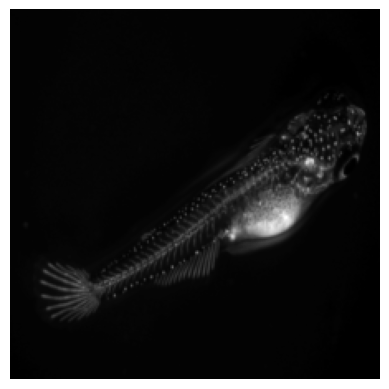

In [22]:
dataset_val = 392
example = dataset[dataset_val] #164

print(example[0].shape)
print(example[1])
plt.axis('off')
plt.imshow(example[0].permute(1, 2, 0).cpu().numpy()[:,:,0], cmap='gray')

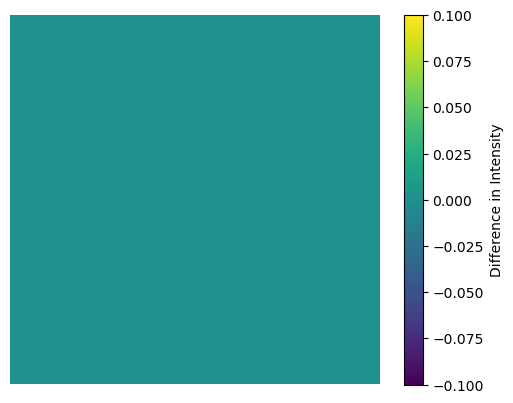

In [25]:
model.eval()
decoder.eval()
embedding = model(example[0].unsqueeze(0).to(device))

phenotype = 2
phenotype2 = 5
genotype = [8.61, -47.7, -167]
genotype2 = [-78.3, -41.1, 7.69]

# embedding[0][phenotype] = genotype[0]
embedding = model(example[0].unsqueeze(0).to(device))
output0 = decoder(embedding)

embedding[0][phenotype] = genotype[0]
output1 = decoder(embedding)

plt.axis('off')
difference = np.abs((output1.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0] - output0.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0]))
# difference = (output1.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0] - output0.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0])
img = plt.imshow(difference > 0.010)
plt.colorbar(img, orientation='vertical', label='Difference in Intensity')
plt.show()

In [85]:
# 14-2_F_x_72-1_M
phenotype = [2, 5, 23, 24, 27, 39, 46, 48, 51, 55, 59, 61, 62, 79, 81, 86, 87, 88, 93, 121]
genotype = [[8.61, -47.7, -167], 
            [-78.3, -41.1, 7.69], 
            [253, 191, 36.9], 
            [65.1, -22.4, -260],
            [36.3, 81.7, 118],
            [-270, -63.5, 24.1],
            [131, 75.8, -33.4],
            [91.8, -51.2, -97.1],
            [49.8, -2.45, -55.7],
            [-113, 16.6, 202],
            [-182, -94.8, 46.1], # X59
            [-102, 40.9, 60.9], # X61
            [194, -5.35, -44.2], # X62
            [-167, -61.3, -0.268], # X79
            [146, 34.6, -91.7], # X81,
            [18.7, -21.4, -82.8], # X86
            [263, 61.1, -71.9], # X87
            [61.6, 16.3, -37.7], # X88
            [53, -40.7, -132], # X93
            [-73.7, 48.8, 118]] # X121

extreme = []
for sublist in genotype:
    if all(x > y for x, y in zip(sublist, sublist[1:])):
        extreme.append(500)
    elif all(x < y for x, y in zip(sublist, sublist[1:])):
        extreme.append(-500)

print(extreme)

[500, -500, 500, 500, -500, -500, 500, 500, 500, -500, -500, -500, 500, -500, 500, 500, 500, 500, 500, -500]


In [92]:
# 95-1_F_x_33-1_M
phenotype = [1, 12, 21, 27, 39, 61, 91, 113, 117]
genotype = [[42.9, 71.3, 167], # X1
            [120, -38.7, -313], # X12
            [172, 54.4, 5.18], # X21
            [148, 56.1, 35.6], # X27
            [-113, 10.1, 44], # X39
            [-57.5, 26.1, 221], # X61
            [-46.6, 36.9, 103], # X91
            [-68.6, -19.6, 151], # 113
            [137, 71.2, -85.4] # 117
]

extreme = []
for sublist in genotype:
    if all(x > y for x, y in zip(sublist, sublist[1:])):
        extreme.append(500)
    elif all(x < y for x, y in zip(sublist, sublist[1:])):
        extreme.append(-500)

print(extreme)

[-500, 500, 500, 500, -500, -500, -500, -500, 500]


In [104]:
# 14-2_M_x_72-1_F
phenotype = [1, 11, 22, 36, 43, 45, 53, 55, 65, 75, 76, 77, 83, 85, 99, 101, 103, 113, 120, 125]
genotype = [[-11.2, -26.1, -143], # X1
            [76.5, 3.76, -43.4], # X11
            [-148, -82.5, -59.5], # X22
            [43.7, 57.9, 113], # X36
            [-137, -48.4, 7.24], # X43
            [-177, -38.8, 110], # X45
            [-148, -112, 48.1], # X53
            [-99, -80.4, 52.7], # X55
            [-107, -15, 108], #X65
            [191, 79.7, -119], # X75
            [494, 590, 751], # X76
            [51.6, 27.2, -61.5], # X77
            [169, 80.1, 18.2], # X83
            [-403, -173, -125], # X85
            [-25.8, -19.2, 36.9], # X99
            [31.3, 16.5, -84.7], # X101
            [-167, -52.5, 73.1], # X103
            [101, 0.741, -173], # X113
            [89.1, 25.9, -189], # X120
            [-330, -213, -32.9] # X125
]

extreme = []
for sublist in genotype:
    if all(x > y for x, y in zip(sublist, sublist[1:])):
        extreme.append(800)
    elif all(x < y for x, y in zip(sublist, sublist[1:])):
        extreme.append(-800)

print(extreme)

[800, 800, -800, -800, -800, -800, -800, -800, -800, 800, -800, 800, 800, -800, -800, 800, -800, 800, 800, -800]


In [100]:
print(len(phenotype) == len(genotype))
print(len(phenotype))

True
20


PLATE 14 F2 VC_ Female 95-1 F14 x Male 33-1 F14_B4.tif
tensor(-150.3370, device='cuda:0', grad_fn=<SelectBackward0>)


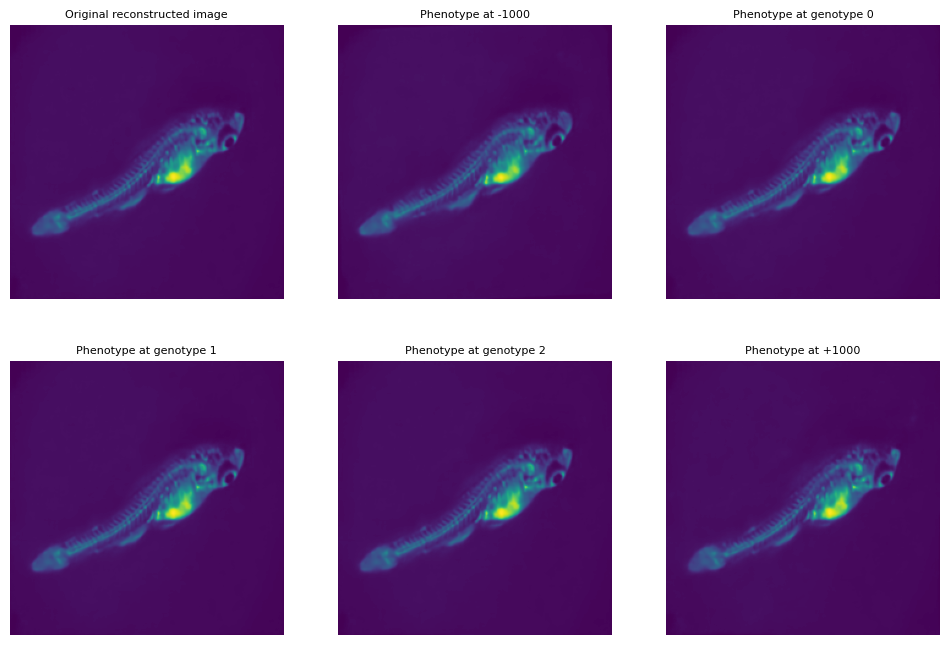

In [18]:
phenotype = 1
# phenotype2 = 23
genotype = [120, -38.7, -313]
# genotype2 = [-78.3, -41.1, 7.69]


model.eval()
decoder.eval()
embedding = model(example[0].unsqueeze(0).to(device))
print(example[1])
# embedding[0][1] = -143
print(embedding[0][phenotype])

# plt.axis('off')
# plt.imshow(example[0].permute(1, 2, 0).cpu().numpy()[:,:,0])

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# fig.suptitle(f"Phenotype reconstruction of {example[1]} ({dataset_val}), phenotype {phenotype}", fontsize=12)
output = decoder(embedding)
axs[0,0].imshow(output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0])
axs[0,0].set_title('Original reconstructed image', fontsize=8)
axs[0,0].axis('off')


# for i in range(len(phenotype)):
#     embedding[0][phenotype[i]] = extreme[i]
    # print(embedding[0][phenotype[i]], extreme[i])
embedding[0][phenotype] = 1000
# embedding[0][phenotype2] = -1000
output = decoder(embedding)
axs[0,1].imshow(output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0])
axs[0,1].set_title('Phenotype at -1000', fontsize=8)
axs[0,1].axis('off')


# for i in range(len(phenotype)):
#     embedding[0][phenotype[i]] = genotype[i][0]
    # print(phenotype[i], genotype[i][0])
embedding[0][phenotype] = genotype[0]
# embedding[0][phenotype2] = genotype2[0]
output = decoder(embedding)
axs[0,2].imshow(output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0])
axs[0,2].set_title('Phenotype at genotype 0', fontsize=8)
axs[0,2].axis('off')


# for i in range(len(phenotype)):
#     embedding[0][phenotype[i]] = genotype[i][1]
embedding[0][phenotype] = genotype[1]
# embedding[0][phenotype2] = genotype2[1]
output = decoder(embedding)
axs[1,0].imshow(output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0])
axs[1,0].set_title('Phenotype at genotype 1', fontsize=8)
axs[1,0].axis('off')


# for i in range(len(phenotype)):
#     embedding[0][phenotype[i]] = genotype[i][2]
embedding[0][phenotype] = genotype[2]
# embedding[0][phenotype2] = genotype2[2]
output = decoder(embedding)
axs[1,1].imshow(output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0])
axs[1,1].set_title('Phenotype at genotype 2', fontsize=8)
axs[1,1].axis('off')
# plt.imshow(output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0])


# for i in range(len(phenotype)):
#     embedding[0][phenotype[i]] = -1*extreme[i]
embedding[0][phenotype] = -1000
# embedding[0][phenotype2] = 1000
output = decoder(embedding)
axs[1,2].imshow(output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0])
axs[1,2].set_title('Phenotype at +1000', fontsize=8)
axs[1,2].axis('off')


plt.show()


In [59]:
print(example[1])

PLATE 14 F2 VC_ Female 95-1 F14 x Male 33-1 F14_B4.tif


PLATE 14 F2 VC_ Female 95-1 F14 x Male 33-1 F14_B4.tif


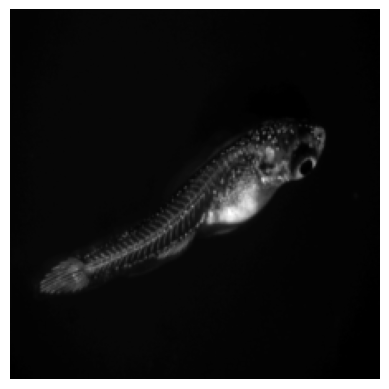

In [53]:
dataset_val = 393
example = dataset[dataset_val]
print(example[1])
plt.axis('off')
plt.imshow(example[0].permute(1, 2, 0).cpu().numpy()[:,:,0], cmap='gray')

model.eval()
decoder.eval()
embedding = model(example[0].unsqueeze(0).to(device))

embedding[0][1] = -1000
output = decoder(embedding)

# plt.axis('off')
# plt.imshow(output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()[:,:,0], cmap='gray')

In [74]:
model.eval()
print(model(example[0].unsqueeze(0)).shape)

torch.Size([1, 128])


### Save the embedding vectors in a df

In [78]:
print(len(dataset))

1112


In [94]:
model.eval()
feature_matrix = {}
counter = 0

for image, image_name in dataset:
    embedding = model(image.unsqueeze(0))
    feature_matrix[image_name] = embedding.detach().cpu().numpy().reshape(128)

    if counter % 10 == 0:
        print(counter)

    counter += 1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110


KeyError: 1112

In [1]:
print(len(feature_matrix))
print(feature_matrix)

NameError: name 'feature_matrix' is not defined

In [101]:
print(feature_matrix['PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif'])

[ -77.71443    -61.410744    29.089512    41.218525    30.065296
  -10.29204    410.0883     -33.349293  -723.1503    -232.67517
  300.89902     20.10732    190.17273    540.12695   -176.24693
   44.52819    100.90983    308.12897    -52.166943   175.80885
 -321.41968    217.52153    526.3035    -365.1253     318.0609
 -209.16046    220.87271    370.936      224.94162    351.8649
  -27.167477   508.67697   -480.5968    -278.52948      4.4324927
  206.6029    -134.35341   -406.53784    346.28265    256.88086
 -181.99242    485.08722   -220.7049    -424.36957   -271.82516
  198.51367    281.1529    -357.6786      77.26173     87.08338
  274.8931    -343.04498    577.7297     516.1294    -364.40228
  136.5843     401.59244    151.21652    -59.072773   373.43015
  377.18597    -21.082111  -476.3881    -143.25397   -324.05157
  202.96922   -438.98062   -364.07556   -109.75923   -419.75226
  173.96829    399.22427     22.354723    10.570647  -542.5288
 -136.3367     360.90564    512.31586   

In [98]:
feature_df = pd.DataFrame.from_dict(feature_matrix, orient='index')
feature_df

feature_df.to_csv("/nfs/research/birney/users/esther/medaka-img/features/convnet-ae-pytorch-medaka/amber-sweep-1-epoch500-feature_matrix.csv")

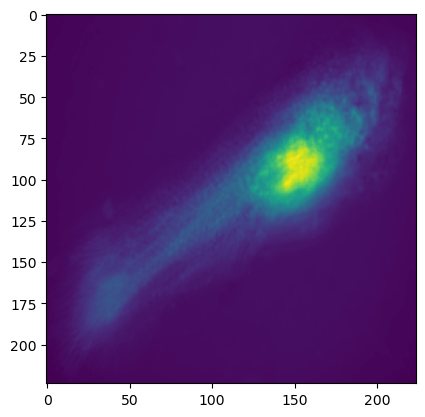

In [25]:
model.to(device)
model_output = model(train_example[0].reshape(-1, 224*224).to(device))

model_output = model_output.reshape(224, 224)
plt.imshow(model_output.cpu().detach().numpy())

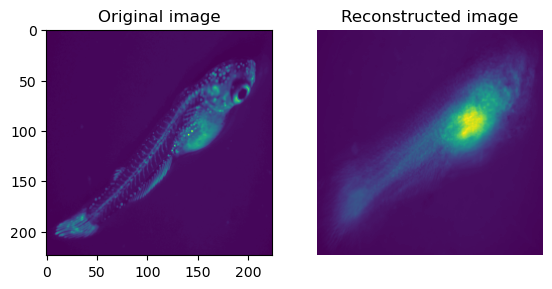

In [26]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(train_example[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Original image')

axs[1].imshow(model_output.cpu().detach().numpy())
axs[1].set_title('Reconstructed image')
axs[1].axis('off')

plt.show()

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

: 